# Codenation  - Data Science

## Squad-4
 * [Brenno Cabella]
 * [Diego Abreu]
 * [Marcelo Amorim]
 * [Nicolas Ribeiro]

### Meta-ranking method

This code provides suggestions for market leads based on an company portfolio (input).
The leads are extracted from a larger data base (market.csv) and a probability is atributed to the most adherent companies from the input portfolio.

The methods used were:

1) Logistic Regression

2) Random Forest

3) One selection from (best accuracy): K-Nearest Neighbor, Support Vector Machines or Decision Tree


The **Random Forest approach** is described below.


The approach used in this study is a random forest classifier with a surrogate null-hypothesis and is implemented by the following steps:

Finding leads using random forest


### Analysis steps:

1) Data treatment (Will be further improved by __data_prep__)

* removes non-informative variables
* transforms boolean and object variables to numeric
* string variables that presents ordinal order are transormed into ordinal numeric
* date variable ('dt_situacao') transfomed into ordinal
* removal of variables that presents at least a given % of nan's
* fill remaining nan's with mode and median for string and numeric variables respectively
* one hot encoding for string variables

2) Model implementation (Radom forest)

* choose input portfolio (file_name_portfolio)

* make_surrogate data

> A little comment on the surrogate approach:

We cannot say for sure that companies listed in market, that does not belong to a given portfolio, are **true not-clients**. They are all, in theory, potential clients and therefore, we cannot attribute label 0 (not-client) to those companies.
To overcome this issue, we proposed to generate surrogate companies that present similar characteristics to those in market but with shuffled values for their variables.
The function **make_surrogate** creates synthetic companies and the label 0 (not-client) is attributed to them. Those surrogate companies are assumed to be **true not-clients** in our model traning.

* Data is divided in 3 parts: train (60%), validation (20%) and test (20%)

* Cross-validation is used to optimize the performance of the model, varying the following parameters: **n_estimators** and **max_depth**.

* Optmized model is used to estimate the performance for the test set

* A model is created using all the data 

* The model is applied to the market file and probabilities of being a client are obtained for each entry

---

> packages

In [123]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import random
from sklearn.metrics import accuracy_score

> read files

In [52]:
market=pd.read_csv("estaticos_market.csv")
market_original=market.copy()
#portfolio_01=pd.read_csv('estaticos_portfolio1.csv')
#portfolio_02=pd.read_csv('estaticos_portfolio2.csv')
#portfolio_03=pd.read_csv('estaticos_portfolio3.csv')

## Data treatment

> Remove variables:
   * non-informative variables (contains just one unique value )
   * 'Unnamed: 0' 

In [53]:
market=market.drop(['Unnamed: 0'],axis=1)
market_fill=market.count()
market=market[market_fill[market_fill>0].index]
market_unique=market.T.apply(lambda x: x.nunique(), axis=1)
list_one=market_unique.index[market_unique.values==1]
market=market[market_unique[market_unique>1].index]
market.shape

(462298, 169)

> Below, the list of non-informative variables removed

In [54]:
list(list_one)

['fl_epp',
 'qt_coligados_nula',
 'qt_coligados_atividade_alto',
 'qt_coligados_atividade_medio',
 'qt_coligados_atividade_baixo',
 'qt_coligados_atividade_mt_baixo',
 'qt_coligados_atividade_inativo']

> change variables values from boolean (True/False) or (SIM/NAO) to numeric (1/0)

In [55]:
bool_var=market.dtypes[market.dtypes=='bool'].index
for i in bool_var: 
    market.loc[market[i]==True,i] = 1
    market.loc[market[i]==False,i] = 0
list_new_bool=('fl_spa',
               'fl_antt',
               'fl_veiculo',
               'fl_optante_simples',
               'fl_optante_simei',
               'fl_simples_irregular',
               'fl_passivel_iss')
for i in list_new_bool: 
    market.loc[market[i]==True,i] = 1
    market.loc[market[i]==False,i] = 0
market.loc[market['fl_rm']=='SIM','fl_rm']=1
market.loc[market['fl_rm']=='NAO','fl_rm']=0

market['fl_spa']=pd.to_numeric(market['fl_spa'])
market['fl_antt']=pd.to_numeric(market['fl_antt'])
market['fl_veiculo']=pd.to_numeric(market['fl_veiculo'])
market['fl_optante_simples']=pd.to_numeric(market['fl_optante_simples'])
market['fl_optante_simei']=pd.to_numeric(market['fl_optante_simei'])
market['fl_simples_irregular']=pd.to_numeric(market['fl_simples_irregular'])
market['fl_passivel_iss']=pd.to_numeric(market['fl_passivel_iss'])

> ordinal order are atributed to object variables (listed below) that presents ordinal "string" values:
   * 'de_faixa_faturamento_estimado_grupo'
   * 'de_faixa_faturamento_estimado'
   * 'idade_emp_cat'
   * 'de_saude_rescencia'
   * 'de_nivel_atividade'
   * 'de_indicador_telefone'

In [56]:
market.loc[market['de_faixa_faturamento_estimado_grupo']=='ATE R$ 81.000,00',
           'de_faixa_faturamento_estimado_grupo']=0
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 81.000,01 A R$ 360.000,00',
           'de_faixa_faturamento_estimado_grupo']=1
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 360.000,01 A R$ 1.500.000,00',
           'de_faixa_faturamento_estimado_grupo']=2
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 1.500.000,01 A R$ 4.800.000,00',
           'de_faixa_faturamento_estimado_grupo']=3
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 4.800.000,01 A R$ 10.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=4
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 10.000.000,01 A R$ 30.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=5
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 30.000.000,01 A R$ 100.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=6
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 100.000.000,01 A R$ 300.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=7
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 300.000.000,01 A R$ 500.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=8
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 500.000.000,01 A 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado_grupo']=9
market.loc[market['de_faixa_faturamento_estimado_grupo']=='ACIMA DE 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado_grupo']=10

market.loc[market['de_faixa_faturamento_estimado']=='ATE R$ 81.000,00',
           'de_faixa_faturamento_estimado']=0
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 81.000,01 A R$ 360.000,00',
           'de_faixa_faturamento_estimado']=1
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 360.000,01 A R$ 1.500.000,00',
           'de_faixa_faturamento_estimado']=2
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 1.500.000,01 A R$ 4.800.000,00',
           'de_faixa_faturamento_estimado']=3
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 4.800.000,01 A R$ 10.000.000,00',
           'de_faixa_faturamento_estimado']=4
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 10.000.000,01 A R$ 30.000.000,00',
           'de_faixa_faturamento_estimado']=5
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 30.000.000,01 A R$ 100.000.000,00',
           'de_faixa_faturamento_estimado']=6
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 100.000.000,01 A R$ 300.000.000,00',
           'de_faixa_faturamento_estimado']=7
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 300.000.000,01 A R$ 500.000.000,00',
           'de_faixa_faturamento_estimado']=8
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 500.000.000,01 A 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado']=9
market.loc[market['de_faixa_faturamento_estimado']=='ACIMA DE 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado']=10
market.loc[market['de_faixa_faturamento_estimado']=='SEM INFORMACAO',
           'de_faixa_faturamento_estimado']=np.nan

market.loc[market['idade_emp_cat']=='<= 1',
           'idade_emp_cat']=0
market.loc[market['idade_emp_cat']=='1 a 5',
           'idade_emp_cat']=1
market.loc[market['idade_emp_cat']=='5 a 10',
           'idade_emp_cat']=2
market.loc[market['idade_emp_cat']=='10 a 15',
           'idade_emp_cat']=3
market.loc[market['idade_emp_cat']=='15 a 20',
           'idade_emp_cat']=4
market.loc[market['idade_emp_cat']=='> 20',
           'idade_emp_cat']=5

market.loc[market['de_saude_rescencia']=='ATE 3 MESES',
           'de_saude_rescencia']=0
market.loc[market['de_saude_rescencia']=='ATE 6 MESES',
           'de_saude_rescencia']=1
market.loc[market['de_saude_rescencia']=='ATE 1 ANO',
           'de_saude_rescencia']=2
market.loc[market['de_saude_rescencia']=='ACIMA DE 1 ANO',
           'de_saude_rescencia']=3
market.loc[market['de_saude_rescencia']=='SEM INFORMACAO',
           'de_saude_rescencia']=np.nan

market.loc[market['de_nivel_atividade']=='MUITO BAIXA',
           'de_nivel_atividade']=0
market.loc[market['de_nivel_atividade']=='BAIXA',
           'de_nivel_atividade']=1
market.loc[market['de_nivel_atividade']=='MEDIA',
           'de_nivel_atividade']=2
market.loc[market['de_nivel_atividade']=='ALTA',
           'de_nivel_atividade']=3

market.loc[market['de_indicador_telefone']=='BOA',
           'de_indicador_telefone']=1
market.loc[market['de_indicador_telefone']=='INDETERMINADA',
           'de_indicador_telefone']=np.nan

market['de_faixa_faturamento_estimado_grupo']=pd.to_numeric(market['de_faixa_faturamento_estimado_grupo'])
market['de_faixa_faturamento_estimado']=pd.to_numeric(market['de_faixa_faturamento_estimado'])
market['de_saude_rescencia']=pd.to_numeric(market['de_saude_rescencia'])
market['idade_emp_cat']=pd.to_numeric(market['idade_emp_cat'])
market['de_nivel_atividade']=pd.to_numeric(market['de_nivel_atividade'])
market['de_indicador_telefone']=pd.to_numeric(market['de_indicador_telefone'])

In [57]:
market.shape

(462298, 169)

> Date variable ('dt_situacao') transfomed to ordinal

In [58]:
test=market['dt_situacao'].dropna()
test=test.astype('datetime64[ns]')
for i in test.index:
    test[i]=test[i].to_pydatetime().toordinal()
market['dt_situacao']=test
market['dt_situacao']=pd.to_numeric(market['dt_situacao'])

> Since there are some variables with many "nan", only the features with at least a given percentage of filled values are chosen.
The following plot presents the number of features that have at least a given percentage of filled values (not nan).

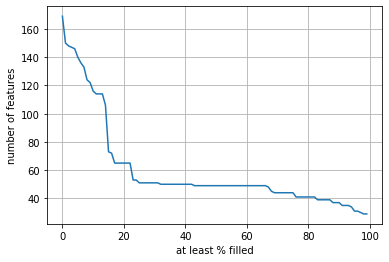

In [59]:
count_market=market.count()
count_market_max=max(count_market)
index = range(0,100)
columns = ['count_features']
n_features = pd.DataFrame(index=index, columns=columns)
for i in range(0,100):
    threshsold=round(i*count_market_max/100)
    n_features.values[i]=sum(count_market>threshsold)
fig, ax = plt.subplots()
ax.plot(n_features)
ax.set(xlabel='at least % filled', ylabel='number of features',
       title='')
ax.grid()

> The **threshold** value provides the minimum amount (%) of data required to inclue the feature in the dataset. 

In [60]:
threshold=0.7

In [61]:
count_market=market.count()
count_market_max=count_market['id']
threshsold_n=round(threshold*count_market_max)
market=market[count_market[count_market>threshsold_n].index]
market.shape

(462298, 44)

> Bar plot showing the features with 'nan' and respective number of 'nan's

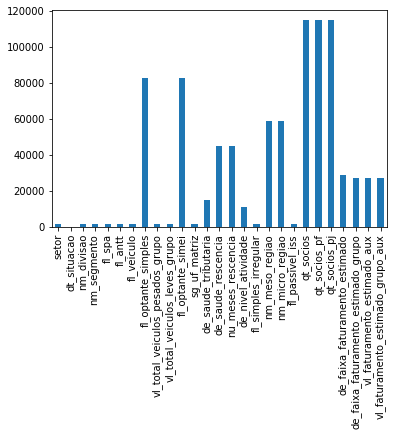

In [62]:
sum_nan=market.isnull().sum(axis = 0)
sum_nan=sum_nan[sum_nan>0]
sum_nan.plot.bar()

> Fill variables above with respective modes

In [63]:
fill_object=sum_nan.index[market.loc[:,sum_nan.index].dtypes=='object']
fill_float64=sum_nan.index[market.loc[:,sum_nan.index].dtypes=='float64']

In [64]:
for i in fill_object:
    market[i] = market[i].fillna(market[i].mode()[0])
for i in fill_float64:
    market[i] = market[i].fillna(market[i].median())

 > One hot encoding for the remaining 'object' variables

In [65]:
market=pd.concat([market,pd.get_dummies(market['de_natureza_juridica'])],axis=1).drop(['de_natureza_juridica'],axis=1)
market=pd.concat([market,pd.get_dummies(market['sg_uf'])],axis=1).drop(['sg_uf'],axis=1)
market=pd.concat([market,pd.get_dummies(market['natureza_juridica_macro'])],axis=1).drop(['natureza_juridica_macro'],axis=1)
market=pd.concat([market,pd.get_dummies(market['de_ramo'])],axis=1).drop(['de_ramo'],axis=1)
market=pd.concat([market,pd.get_dummies(market['setor'])],axis=1).drop(['setor'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_divisao'])],axis=1).drop(['nm_divisao'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_segmento'])],axis=1).drop(['nm_segmento'],axis=1)
market=pd.concat([market,pd.get_dummies(market['sg_uf_matriz'],prefix='matriz')],axis=1).drop(['sg_uf_matriz'],axis=1)
market=pd.concat([market,pd.get_dummies(market['de_saude_tributaria'])],axis=1).drop(['de_saude_tributaria'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_meso_regiao'])],axis=1).drop(['nm_meso_regiao'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_micro_regiao'])],axis=1).drop(['nm_micro_regiao'],axis=1)
market.shape

(462298, 384)

##  Radom forest model

For a given input portfolio, first we identify indexes of the listed companies in the market database.
A vector y is created with label 0 or 1 to each index according to its respective status: not client or client, respectively.

### Choose portfolio (input)

In [250]:
file_name_portfolio="estaticos_portfolio1.csv"

In [251]:
input_file=pd.read_csv(file_name_portfolio)
input_id=input_file['id']
index_True=market[market['id'].isin(input_id.values)].index
input_portfolio=market.loc[index_True]
input_portfolio.head()

,id,fl_matriz,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_mei,fl_ltda,dt_situacao,fl_st_especial,...,SERIDO OCIDENTAL,SERIDO ORIENTAL,SERRA DE SANTANA,SERRA DE SAO MIGUEL,TARAUACA,TEFE,TERESINA,UMARIZAL,VALE DO ACU,VALENCA DO PIAUI
369,dabe79bec87c88ae04e869bf6bd321ee5e1893cecf6625...,1,0.646575,0,0,0,1,0,736759.0,0,...,0,0,0,0,0,0,0,0,0,0
604,32e5f4e10932153a7ba869cb0386e7e02d49d2461046b8...,0,6.586301,2,0,0,0,0,734591.0,0,...,0,0,0,0,0,0,0,0,0,0
1703,a95d6f30bba445bd3d6b0c5b36f865b38ec01d17336090...,1,8.010959,2,0,0,1,0,734071.0,0,...,0,0,0,0,0,0,0,0,0,0
2521,6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e...,1,20.863014,5,0,0,0,0,732253.0,0,...,0,0,0,0,0,0,0,1,0,0
5788,f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc25...,1,18.726027,4,0,0,0,0,732253.0,0,...,0,0,0,0,0,0,0,0,0,0


Generate surrogates

In [252]:
def make_surrogate(df,samples):
    mod_df=pd.DataFrame(columns=df.columns)
    random.seed(1)
    seed=np.random.randint(1,10000,size=len(df.columns))
    count_seed=0
    for i in df.columns:
        mod_df[i]=np.array(df[i].sample(n=samples, random_state=seed[count_seed],replace=True))
        count_seed += 1 
    return mod_df

In [253]:
surr_market=make_surrogate(market.drop('id',axis=1),len(input_portfolio))

In [254]:
index_True=market[market['id'].isin(input_portfolio['id'].values)].index
input_portfolio=market.loc[index_True]
X=pd.concat([surr_market,input_portfolio.drop('id',axis=1)])
X.shape

(1110, 383)

In [255]:
y=pd.DataFrame(np.zeros(len(X)),index=X.index)
y.loc[index_True]=1

Data is divided in 3 parts:
* train (60%)
* validation (20%)
* test (20%)

Cross-validation was used to optimize the performance of the model, varying the following parameters:

* n_estimators
* max_depth

In [256]:
X_train_base, X_test, y_train_base, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model optmization

In [257]:
grid_n_estimators=range(110,135,5)
grid_max_depth=range(95,115,5)

In [258]:
max_k=10 # number of cross-validation
f1=pd.DataFrame(columns=['n_estimators','max_depth','tp','fp','tn','fn','acc'])
count=0
start = time.process_time()
for est in grid_n_estimators:
    for dep in grid_max_depth:
        rf = RandomForestClassifier(n_estimators=est,max_depth=dep)
        tp=0
        fp=0
        fn=0
        tn=0
        for k in range(1,(max_k+1)):
            X_train, X_val, y_train, y_val = train_test_split(X_train_base, y_train_base, 
                                                              test_size=0.2, random_state=k)  
            rf.fit(X_train, y_train.values.ravel())
            predictions = rf.predict(X_val)
            aux_matrix=confusion_matrix(y_val, predictions)
            tn=tn+aux_matrix[0][0]
            fp=fp+aux_matrix[0][1]
            fn=fn+aux_matrix[1][0]
            tp=tp+aux_matrix[1][1]
        f1.loc[count,'n_estimators']=est
        f1.loc[count,'max_depth']=dep
        f1.loc[count,'tn']=tn
        f1.loc[count,'fp']=fp
        f1.loc[count,'fn']=fn
        f1.loc[count,'tp']=tp
        f1.loc[count,'acc']=(tp+tn)/(tp+tn+fp+fn)
        count+=1
run_time=round(time.process_time() - start)
run_time

24

Optimal values 

In [259]:
opt_test=f1[f1['acc']==f1['acc'].min()]
opt_est=opt_test['n_estimators'].min()
opt_dep=opt_test['max_depth'].min()
print('n_estimators=', opt_est)
print('max_depth=', opt_dep)

n_estimators= 110
max_depth= 105


Run analysis for test data using optimal parameters

In [260]:
rf_opt = RandomForestClassifier(n_estimators=opt_est,max_depth=opt_dep)
rf_opt.fit(X_train_base, y_train_base.values.ravel())
#rf_opt.fit(X_test, y_test.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=105, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Confusion matrix of the model applied to the test set

In [261]:
predictions_test = rf.predict(X_test)
print('confusion matrix for test set')
print(confusion_matrix(y_test, predictions_test))
print('')
print('acc=', round(accuracy_score(y_test, predictions_test),3))

confusion matrix for test set
[[122   0]
 [  1  99]]

acc= 0.995


In [262]:
out_first=rf_opt.predict_proba(market.drop('id',axis=1))
out_bin=rf_opt.predict(market.drop('id',axis=1))

In [263]:
RF_rank=pd.DataFrame(columns=['prob'], index=market['id'])
RF_rank['prob']=out_first[:,1]
RF_rank=RF_rank.sort_values(by='prob',ascending=False)
RF_rank_portfolio=RF_rank.loc[input_id.values,:]
RF_rank=RF_rank.drop(input_id.values,axis=0)

Distribution of probabilities for the market file wtihout portfolio

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ff4191a20>]],
      dtype=object)

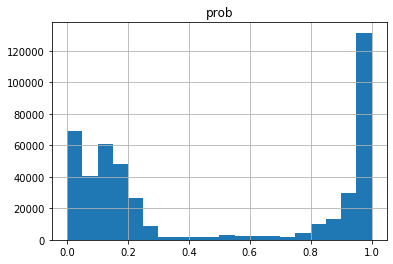

In [264]:
RF_rank.hist(bins=20)

Distribution of probabilities for the portfolio

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fddc8f5c0>]],
      dtype=object)

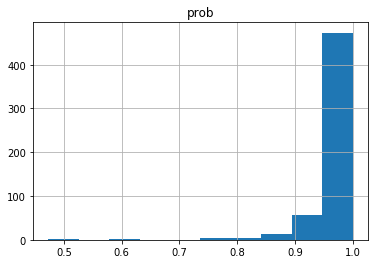

In [265]:
RF_rank_portfolio.hist()

Consider only classified as client (prob>0.5)

In [266]:
prob_cut=0.8

In [267]:
RF_rank=RF_rank[RF_rank['prob']>=prob_cut]
RF_rank.shape

(184261, 1)

Save list of ids with respective probabilities

In [268]:
out_name='RF_'+ file_name_portfolio
RF_rank.to_csv(out_name)

In [ ]:
### performance

In [269]:
out_final=market_original[market_original['id'].isin(RF_rank.index)]
portfolio_all=market_original[market_original['id'].isin(input_portfolio['id'])]

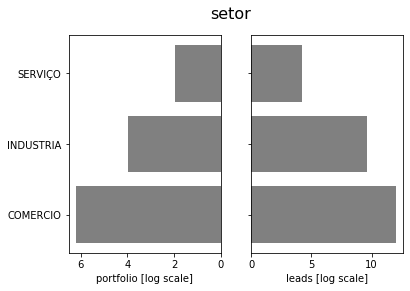

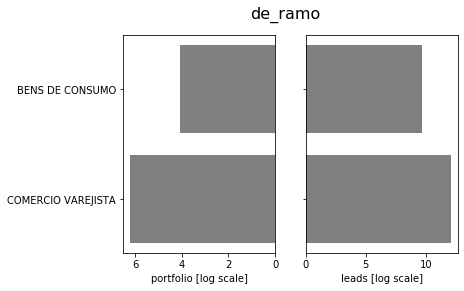

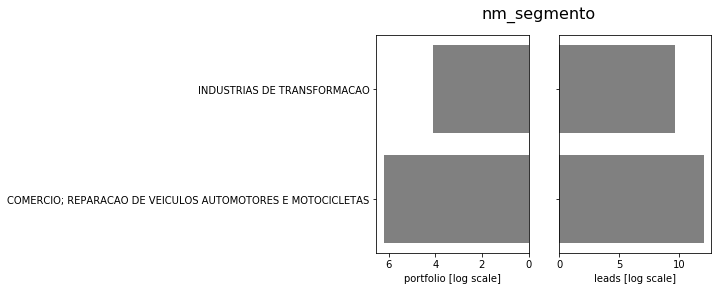

In [270]:
list_compare=['setor','de_ramo','nm_segmento']
for variable in list_compare:
    fig, axes = plt.subplots(ncols=2, sharey=True)
    axes[0].barh(portfolio_all[variable].value_counts().index, np.log(portfolio_all[variable].value_counts()), align='center', color='gray')
    axes[1].barh(out_final[variable].value_counts().index, np.log(out_final[variable].value_counts()), align='center', color='gray')
    axes[0].invert_xaxis()
    axes[1].set_xlabel('leads [log scale]')
    axes[0].set_xlabel('portfolio [log scale]')
    fig.suptitle(variable, fontsize=16)
    plt.show()

Possible post-processing filters: 

Removing companies that does not share the following caracteristics with the input portfolio:
* 'de_ramo'
* 'setor'
* 'nm_segmento'
* 'nm_divisao'
* 'natureza_juridica_macro'
* 'de_natureza_juridica'
* 'nm_meso_regiao'
* 'nm_micro_regiao'

Also, only the leads with the following characteristics are included:

* 'fl_st_especial'= False
* 'fl_simples_irregular'= False
* 'de_saude_tributaria' = 'VERDE'
* 'nu_meses_rescencia' <= 24
* 'de_nivel_atividade' = 'ALTA'
* 'de_indicador_telefone' = 'BOA'

---